In [ ]:
#Note:
#In this tutorial you will learn how to use CAC Python library for solving gas phase distribution in porous media using saturation-conditioned U-Net
#We provide: 10 saturated structures and their labels with the size 300 x 300 pixels for training, 
#            5 saturated structures and their labels with the size 300 x 300 pixels for validation

In [21]:
#Import external libraries
import numpy
import os
import shutil
import time
import cv2
import matplotlib.pyplot as plt

from sklearn import preprocessing

In [22]:
#Import CAC python library
from cac import model, trainer, utilities

In [ ]:
#Before going further, we need to first understand that saturation-conditioned takes binary fully-saturated structure and saturation scalar as input
#                      the output is binary partially-saturated structure
#
#Note that, U-Net needs to operate at 2^n size for its input image. Hence, we resize our images into 256 x 256 pixels using OepnCV Python library
#
#Therefore, here, we first load the binary fully-saturated structures
training_image = numpy.zeros((10, 256, 256, 1)) #500 is the number of training samples, 256 is the width of input image, 256 is the height of input image, and 1 for binary quality

for ww in range(10):

    #Read images from folder, we already named the images using number, ushc as 0.png, 1.png, ...
    filename    = 'data/training/images/' + str(ww) + '.png'
    image_array = cv2.imread(filename, cv2.IMREAD_GRAYSCALE) #reading images using grayscale
    image_array = cv2.resize(image_array, (256, 256)) #resizing to 256 x 256
    image_array = image_array / 255 #scaling to 0 and 1
    image_array[image_array < 0.5]  = 0 #thresholding 
    image_array[image_array >= 0.5] = 1 #thresholding 
    training_image[ww, :, :, 0] = image_array[:, :]

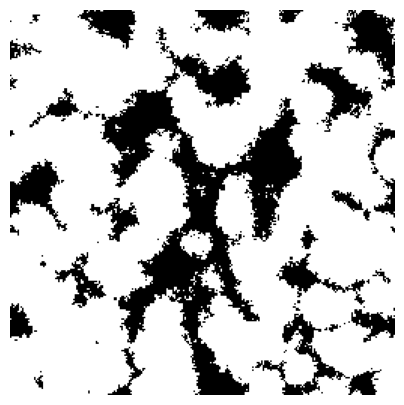

In [24]:
#Show input training images
plt.figure(figsize=(5,5))
plt.imshow(training_image[0,:,:,:]*255, cmap='gray') 
plt.axis('off')
plt.show()

In [ ]:
#Collect training saturation values
training_saturation = numpy.load('data/training/images/saturation.npy')[0:10,:]

In [26]:
#Show input saturation
print(training_saturation)

[[0.54767663]
 [1.        ]
 [0.70362136]
 [0.59845541]
 [1.        ]
 [0.64929782]
 [1.        ]
 [0.60115651]
 [1.        ]
 [1.        ]]


In [27]:
#Scale training saturation values
inputs_scaler = preprocessing.MinMaxScaler().fit(training_saturation)
scaled_training_saturation = inputs_scaler.transform(training_saturation)

In [ ]:
#Save scaling factor
scaling_factor = []
scaling_factor.append(inputs_scaler.data_min_)
scaling_factor.append(inputs_scaler.data_max_)
scaling_factor = numpy.asarray(scaling_factor)

numpy.save("results/inputs_minmax_scaling_factor", scaling_factor)

In [ ]:
#Note that, the label contains gas phase colored as white. Therefore, the label itself is binary.
#
#Collect training labels
training_label = numpy.zeros((10, 256, 256, 1)) #500 is the number of training samples, 256 is the width of input image, 256 is the height of input image, and 1 for binary quality

for ww in range(10):

    #Read images from folder, we already named the images using number, ushc as 0.png, 1.png, ...
    filename    = 'data/training/labels/' + str(ww) + '.png'
    image_array = cv2.imread(filename, cv2.IMREAD_GRAYSCALE) #reading images using grayscale
    image_array = cv2.resize(image_array, (256, 256)) #resizing to 256 x 256
    image_array = image_array / 255 #scaling to 0 and 1
    image_array[image_array < 0.5]  = 0 #thresholding 
    image_array[image_array >= 0.5] = 1 #thresholding 
    training_label[ww, :, :, 0] = image_array[:, :]

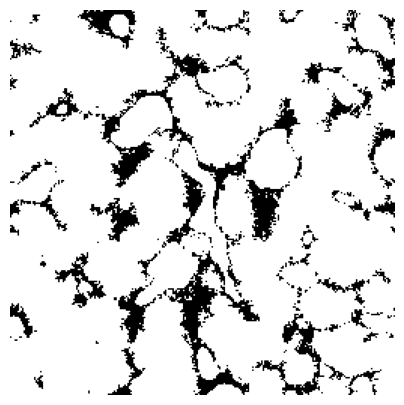

In [30]:
#Show training labels
plt.figure(figsize=(5,5))
plt.imshow(training_label[0,:,:,:]*255, cmap='gray') 
plt.axis('off')
plt.show()

In [ ]:
#Collect validation images
test_image = numpy.zeros((5, 256, 256, 1)) #500 is the number of training samples, 256 is the width of input image, 256 is the height of input image, and 1 for binary quality

for ww in range(5):

    #Read images from folder, we already named the images using number, ushc as 0.png, 1.png, ...
    filename    = 'data/test/images/' + str(ww) + '.png'
    image_array = cv2.imread(filename, cv2.IMREAD_GRAYSCALE) #reading images using grayscale
    image_array = cv2.resize(image_array, (256, 256)) #resizing to 256 x 256
    image_array = image_array / 255 #scaling to 0 and 1
    image_array[image_array < 0.5]  = 0 #thresholding 
    image_array[image_array >= 0.5] = 1 #thresholding 
    test_image[ww, :, :, 0] = image_array[:, :]

In [32]:
#Collect test saturation values
test_saturation = numpy.load('/home/santoso1/simulation/cac/examples/tutorial_2/data/test/images/saturation.npy')[0:5,:]

In [33]:
#Scale test saturation values
scaled_test_saturation  = inputs_scaler.transform(test_saturation)

In [ ]:
#Collect test labels
test_label = numpy.zeros((5, 256, 256, 1)) #500 is the number of training samples, 256 is the width of input image, 256 is the height of input image, and 1 for binary quality

for ww in range(5):

    #Read images from folder, we already named the images using number, ushc as 0.png, 1.png, ...
    filename    = 'data/test/labels/' + str(ww) + '.png'
    image_array = cv2.imread(filename, cv2.IMREAD_GRAYSCALE) #reading images using grayscale
    image_array = cv2.resize(image_array, (256, 256)) #resizing to 256 x 256
    image_array = image_array / 255 #scaling to 0 and 1
    image_array[image_array < 0.5]  = 0 #thresholding 
    image_array[image_array >= 0.5] = 1 #thresholding 
    test_label[ww, :, :, 0] = image_array[:, :]

In [35]:
#Create saturation-conditioned U-Net. Here, the function is called tfunet (transformed U-Net)
unet = model.create_tfunet(training_image, scaled_training_saturation, training_label, 
                           encoder_depth=4,
                           number_filters_at_first_encoder=32,
                           neurons_in_layer1=10,
                           neurons_in_layer2=10,
                           learning_rate=1.0,  
                           distributed=False, #without GPU; if you have GPU put True
                           unet_activation_function='relu',
                           unet_output_activation_function='sigmoid',
                           conditioning_activation_function='sigmoid',
                           info=True) #Put True if you want to see the deatiled architecture

This is your model's architecture:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer_image (InputLa  [(None, 256, 256, 1)]        0         []                            
 yer)                                                                                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 256, 256, 32)         320       ['input_layer_image[0][0]']   
                                                                                                  
 batch_normalization_14 (Ba  (None, 256, 256, 32)         128       ['conv2d_9[0][0]']            
 tchNormalization)                                                                                
                                                         

In [ ]:
#Define training
trained_unet = trainer.train_tfunet(training_image, scaled_training_saturation, training_label,
                                    unet, batch_size=10, epochs=1,  
                                    distributed=False, #without GPU; if you have GPU put True
                                    save_path='results')


INFO:tensorflow:Assets written to: /home/santoso1/simulation/cac/examples/tutorial_2/results/trained_model.tf/assets


INFO:tensorflow:Assets written to: /home/santoso1/simulation/cac/examples/tutorial_2/results/trained_model.tf/assets


In [ ]:
#Calculate metric for validation set
test_error = trainer.calculate_image_metric_tfunet(test_image, scaled_test_saturation, test_label,
                                                   trained_unet,
                                                   save_path='results')
print(test_error)


5/5 [==============================] - 1s 114ms/step
0.16907488672446394


In [38]:
#Display
print("Our test error: " + str(test_error))

Our test error: 0.16907488672446394
